In [194]:
from PIL import Image
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [195]:
class PairedSlotMachineEnv(gym.Env):
    def __init__(self):
        super(PairedSlotMachineEnv, self).__init__()

        # Define action space: pick option 1 or option 2 in the current pair
        self.action_space = spaces.Discrete(2)
        
        # Observation space: represent each machine with its index and indicator status (0 or 1)
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(2, 64, 64),  # Two channels (one for each image), height, width
            dtype=np.float32
        )
        
        # Define slot machine points and probabilities
        self.points = {
            'A': 10, 'B': 10, 'C': 1, 'D': 1,
            'E': 10, 'F': 10, 'G': 1, 'H': 1
        }
        self.probabilities = {
            'A': 0.75, 'B': 0.25, 'C': 0.75, 'D': 0.25,
            'E': 0.75, 'F': 0.25, 'G': 0.75, 'H': 0.25
        }

        # Image paths for each symbol
        self.image_paths = {
            "A": {"woSymbol": "./ResizedSymbols64/SymbolA.png", "wSymbol": "./ResizedSymbols64/SymbolA_R.png"},
            "B": {"woSymbol": "./ResizedSymbols64/SymbolB.png", "wSymbol": "./ResizedSymbols64/SymbolB_R.png"},
            "C": {"woSymbol": "./ResizedSymbols64/SymbolC.png", "wSymbol": "./ResizedSymbols64/SymbolC_R.png"},
            "D": {"woSymbol": "./ResizedSymbols64/SymbolD.png", "wSymbol": "./ResizedSymbols64/SymbolD_R.png"},
            "E": {"woSymbol": "./ResizedSymbols64/SymbolE.png", "wSymbol": "./ResizedSymbols64/SymbolE_R.png"},
            "F": {"woSymbol": "./ResizedSymbols64/SymbolF.png", "wSymbol": "./ResizedSymbols64/SymbolF_R.png"},
            "G": {"woSymbol": "./ResizedSymbols64/SymbolG.png", "wSymbol": "./ResizedSymbols64/SymbolG_R.png"},
            "H": {"woSymbol": "./ResizedSymbols64/SymbolH.png", "wSymbol": "./ResizedSymbols64/SymbolH_R.png"},
        }

        # Initialize self.images with the same structure as self.image_paths
        self.images = {symbol: {} for symbol in self.image_paths}

        # Iterate through image paths and preprocess each image
        for symbol, paths in self.image_paths.items():
            for key, path in paths.items():
                # Preprocess the image and store it in self.images
                self.images[symbol][key] = self._preprocess_image(path)


        # Original pairs for Learning Phase and new pairs for Transfer Phase
        self.learning_pairs = [('A', 'B'), ('C', 'D'), ('E', 'F'), ('G', 'H')]
        self.transfer_pairs = [('A', 'C'), ('B', 'D'), ('E', 'H'), ('F', 'G')]
        self.transfer_phase = False  # Start in learning phase by default
        self.current_pair = None
        self.rewards = None
        self.indicators = None

        # Initialize logs to track each action taken by the agent
        self.logs = []

    def set_transfer_phase(self, transfer: bool):
        """Toggle between learning and transfer phases."""
        self.transfer_phase = transfer

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_pair = self._get_random_pair()
        obs = self._get_observation()
        return obs, {}
    
    def _get_random_pair(self):
        # Select from learning pairs or transfer pairs based on the phase
        pairs = self.transfer_pairs if self.transfer_phase else self.learning_pairs
        pair = pairs[np.random.randint(len(pairs))]
        # Randomly shuffle the order with 50% probability
        if np.random.rand() < 0.5:
            pair = pair[::-1]
        return pair
       
    def _get_img(self, reward_given, machine):
        """
        Adjust the logic to ensure 95% alignment between reward and indicator,
        and 5% the opposite alignment.
        """
        if reward_given:
            # Show the 'with symbol' image 95% of the time
            has_symbol = np.random.rand() < 0.95
            img = self.images[machine]['wSymbol'] if has_symbol else self.images[machine]['woSymbol']
        else:
            # Show the 'without symbol' image 95% of the time
            has_symbol = np.random.rand() < 0.05
            img = self.images[machine]['woSymbol'] if has_symbol else self.images[machine]['wSymbol']
                    
        return img, has_symbol

    
    def _preprocess_image(self, path):
        """Load and preprocess the image from the given path."""
        img = Image.open(path).convert('L')  # Convert to grayscale
        img_data = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values to [0, 1]
        img_with_channel = np.expand_dims(img_data, axis=0)  # Add the channel dimension (1, height, width)
        return img_with_channel
    
    def _get_observation(self):
        preprocessed_images = []
    
        # Sample rewards and indicator statuses once, store them in instance variables
        self.rewards = []
        self.indicators = []
    
        for machine in self.current_pair:
            reward_given = np.random.rand() < self.probabilities[machine]
            reward = self.points[machine] if reward_given else 0
            self.rewards.append(reward)
            img, has_symbol = self._get_img(reward_given, machine)
            self.indicators.append(1 if has_symbol else 0)
            preprocessed_images.append(img[0])  # Remove the channel-first dimension here
    
        # Stack images along the channel dimension (2, 20, 20)
        return np.stack(preprocessed_images, axis=0)

    
    def step(self, action):
        # Use the pre-sampled reward for the selected action
        reward = self.rewards[action]
        
        # Log the outcome in the desired format
        log_entry = {
            'pair': ''.join(self.current_pair),
            'lSymbol': self.current_pair[0],
            'rSymbol': self.current_pair[1],
            'lIndicator': bool(self.indicators[0]),
            'rIndicator': bool(self.indicators[1]),
            'symbolPicked': self.current_pair[action]
        }
        self.logs.append(log_entry)
        
        # Select a new random pair for the next step
        self.current_pair = self._get_random_pair()
        
        # Get the new observation (with updated pre-sampled rewards and indicators)
        observation = self._get_observation()
        return observation, reward, False, False, {}

    def render(self):
        print(f"Current pair: {self.current_pair[0]} (with indicator {self.indicators[0]}) "
              f"vs {self.current_pair[1]} (with indicator {self.indicators[1]})")

    def get_logs(self):
        # Return the full log for analysis
        return self.logs


In [196]:
def plot_choices_over_time(df, pair, lSymbol, rSymbol):
    # Filter data for the specific pair and both positions
    pair_df = df[(df['pair'] == pair)]

    # Iterate over all indicator combinations
    indicator_combinations = pair_df[['lIndicator', 'rIndicator']].drop_duplicates()

    for _, comb in indicator_combinations.iterrows():
        l_ind = comb['lIndicator']
        r_ind = comb['rIndicator']
        
        # Filter for the specific indicator combination
        subset = pair_df[(pair_df['lIndicator'] == l_ind) & (pair_df['rIndicator'] == r_ind)]

        # Calculate cumulative counts for each symbol
        subset['time'] = range(len(subset))  # Add a time step column
        cumulative_counts = subset.groupby('time')['symbolPicked'].value_counts().unstack(fill_value=0).cumsum()

        # Plot the cumulative counts
        plt.figure(figsize=(10, 6))
        for symbol in [lSymbol, rSymbol]:
            plt.plot(cumulative_counts.index, cumulative_counts[symbol], label=f'Symbol {symbol}')

        # Add labels, title, and legend
        plt.title(f"Choices over Time for Pair {pair} (lIndicator={l_ind}, rIndicator={r_ind})")
        plt.xlabel("Time Step")
        plt.ylabel("Cumulative Count of Choices")
        plt.legend()
        plt.grid()
        plt.show()
        plt.close()  # Ensure the plot does not overlap in Jupyter

In [197]:
# Initialize the environment
env = PairedSlotMachineEnv()
check_env(env)

# Create the PPO model with CnnPolicy and disable additional normalization
policy_kwargs = dict(normalize_images=False)
model = PPO("CnnPolicy", env, verbose=1, gamma=1, ent_coef=0.01,learning_rate=3e-4, policy_kwargs=policy_kwargs)

# Train the model
model.learn(total_timesteps=10000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 369  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 2          |
|    time_elapsed         | 14         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03174091 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.673     |
|    explained_variance   | 0.000163   |
|    learning_rate        | 0.0003     |
|    loss                 | 110        |
|    n_updates            | 10         |
|    policy_gradient_loss | 0.0101     |
|    value_loss           | 309        

10251
  pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
0   GH       G       H       False        True            G
1   FE       F       E       False        True            E
2   EF       E       F       False       False            E
3   FE       F       E       False        True            E
4   EF       E       F       False       False            F
5   CD       C       D        True       False            C
6   HG       H       G       False        True            G
7   HG       H       G        True        True            G
8   EF       E       F       False        True            E
9   HG       H       G       False        True            G


C:\Users\Prod\AppData\Local\Temp\ipykernel_8644\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


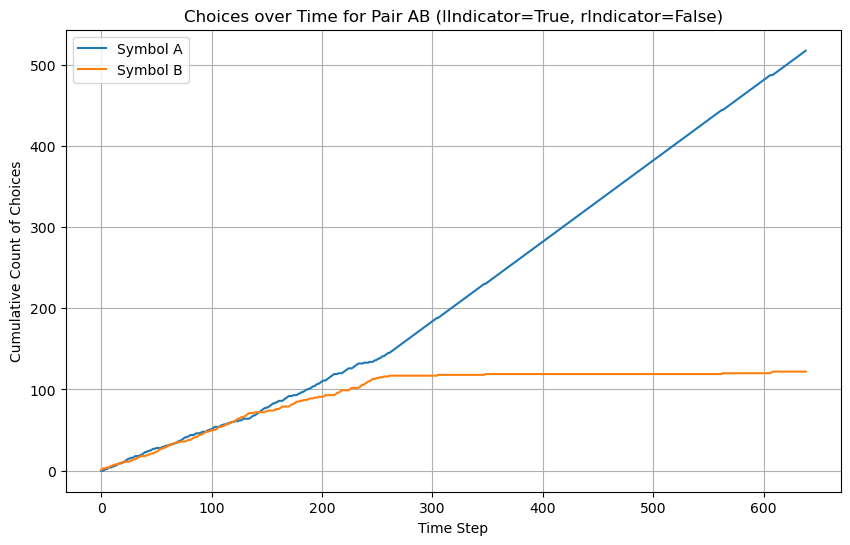

C:\Users\Prod\AppData\Local\Temp\ipykernel_8644\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


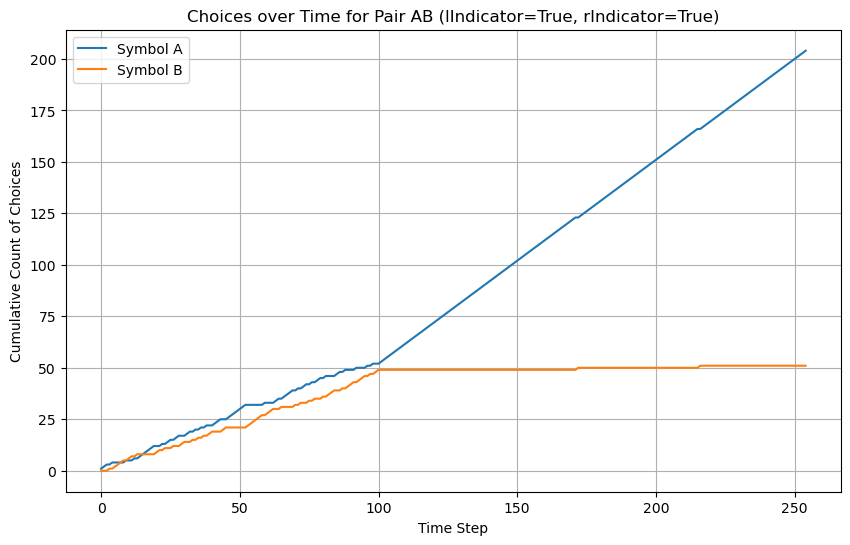

C:\Users\Prod\AppData\Local\Temp\ipykernel_8644\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


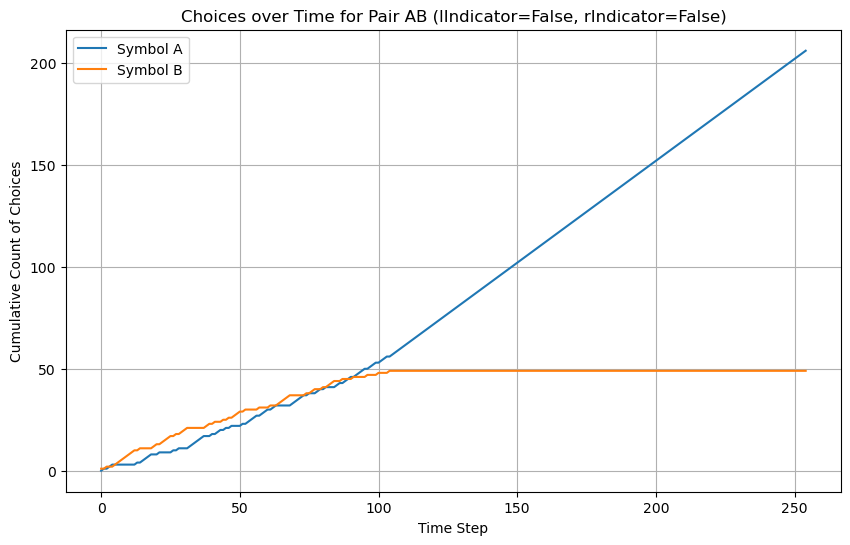

C:\Users\Prod\AppData\Local\Temp\ipykernel_8644\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


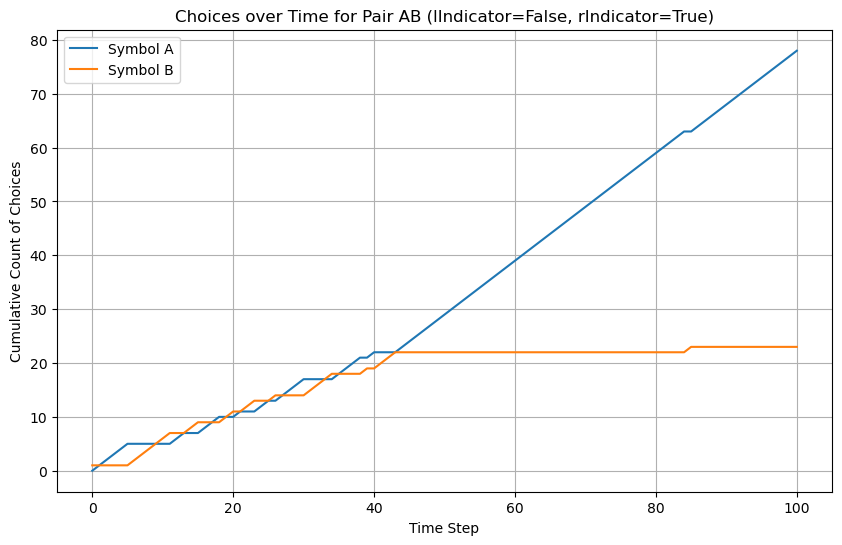

C:\Users\Prod\AppData\Local\Temp\ipykernel_8644\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


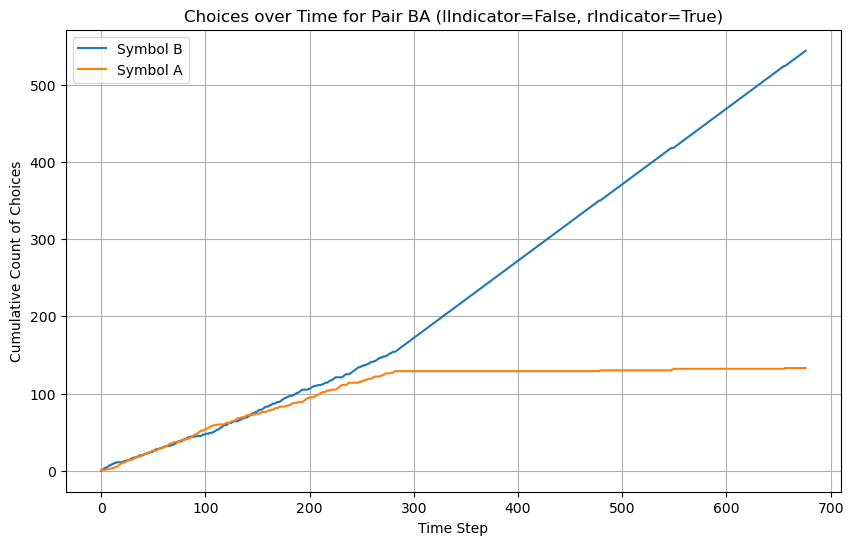

C:\Users\Prod\AppData\Local\Temp\ipykernel_8644\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


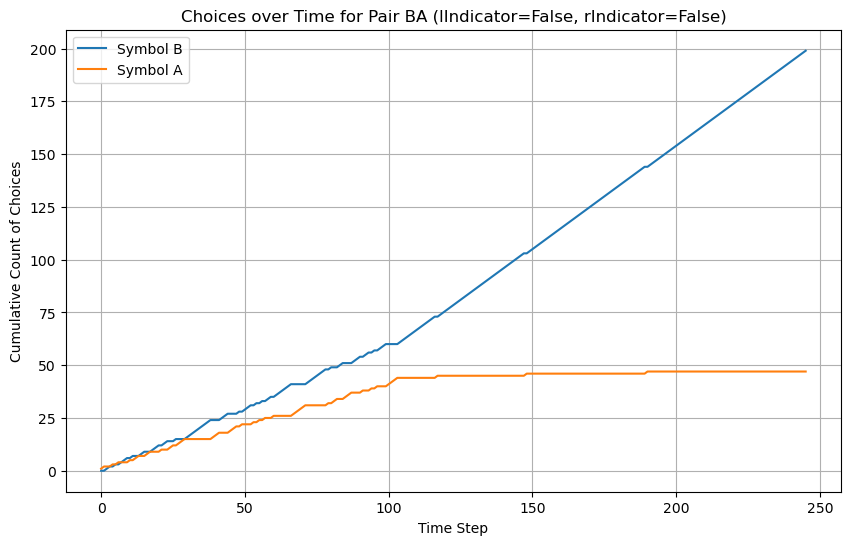

C:\Users\Prod\AppData\Local\Temp\ipykernel_8644\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


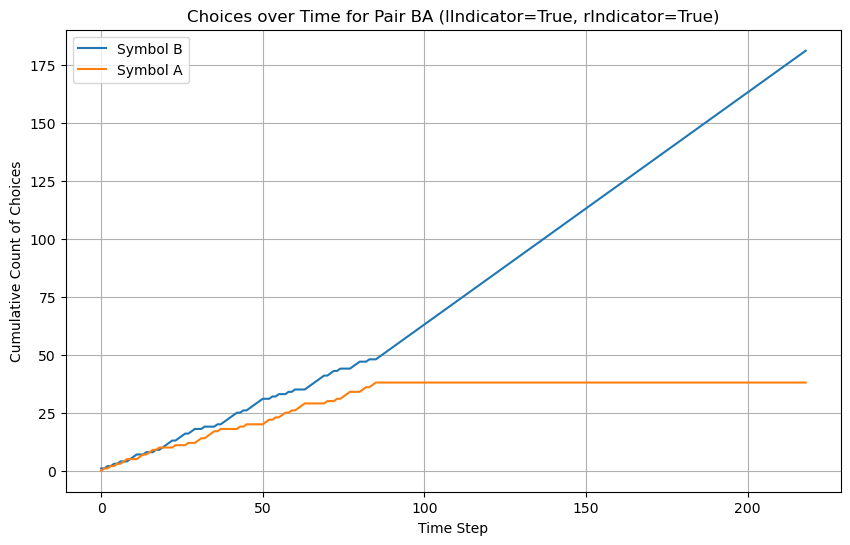

C:\Users\Prod\AppData\Local\Temp\ipykernel_8644\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


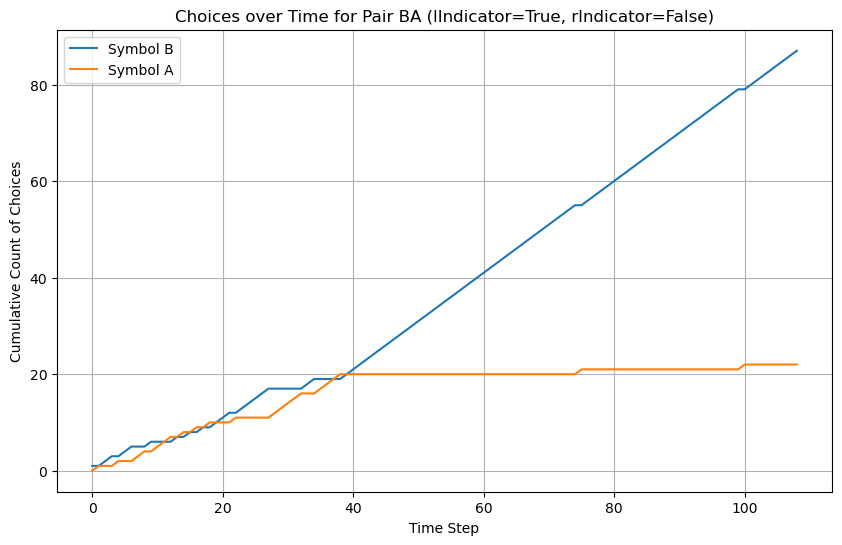

In [198]:
logs = env.get_logs()
logs = pd.DataFrame(logs)
print(len(logs)) 
print(logs.iloc[0:10])

# Plot choices for pair 'AB' where A and B switch positions
plot_choices_over_time(logs, pair='AB', lSymbol='A', rSymbol='B')
plot_choices_over_time(logs, pair='BA', lSymbol='B', rSymbol='A')

In [199]:
# Count the number of times each pair showed up in each configuration
pair_config_counts = logs.groupby(['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator']).size().reset_index(name='count')

# Display the results
#print(pair_config_counts)


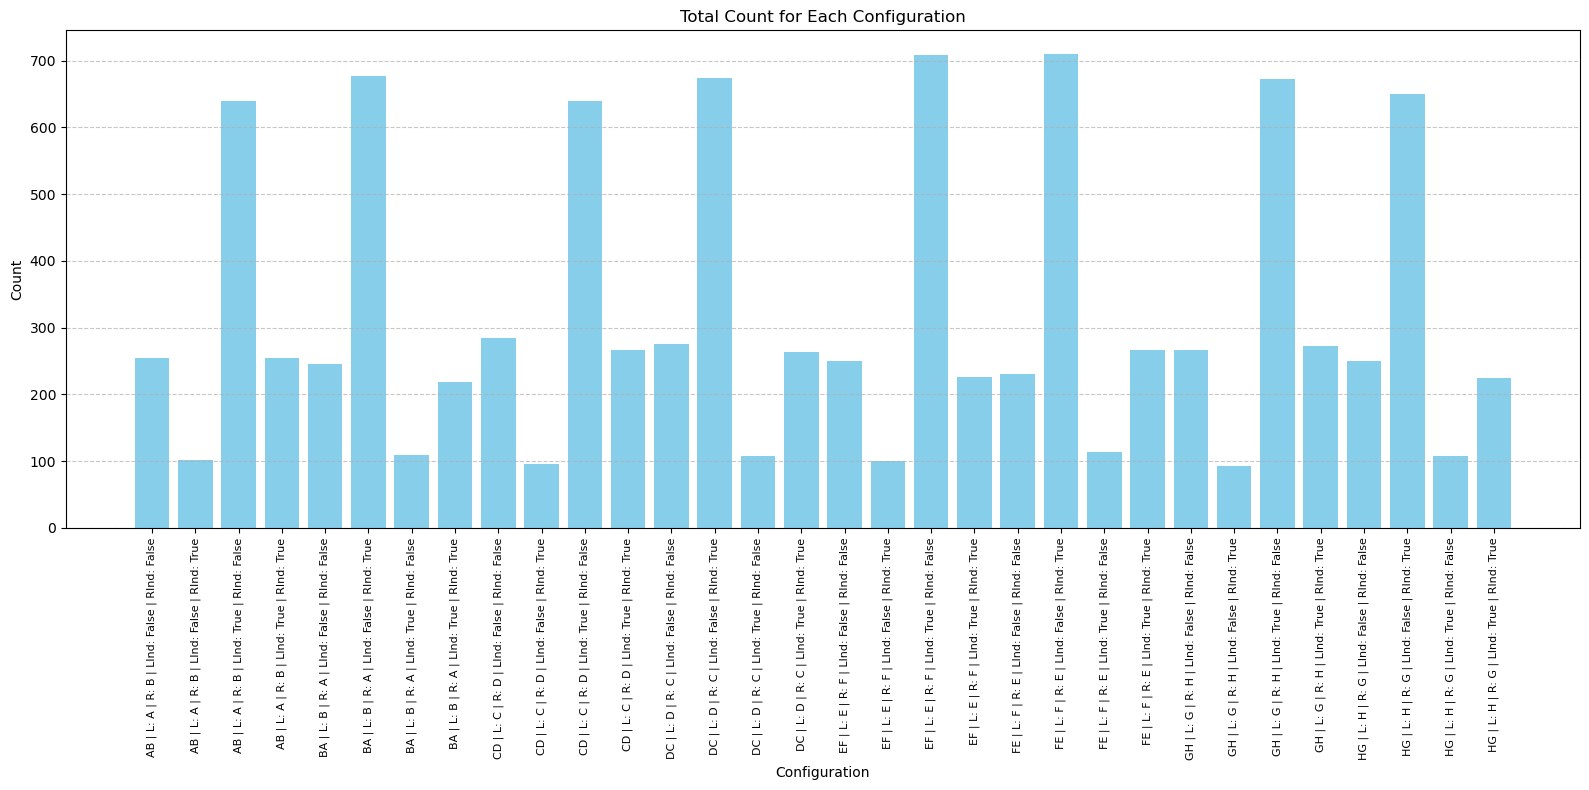

In [200]:
# Create a column for configuration labels for easier plotting
pair_config_counts['configuration'] = (
    pair_config_counts['pair'] + 
    " | L: " + pair_config_counts['lSymbol'] + 
    " | R: " + pair_config_counts['rSymbol'] + 
    " | LInd: " + pair_config_counts['lIndicator'].astype(str) + 
    " | RInd: " + pair_config_counts['rIndicator'].astype(str)
)

# Sort by pair and configuration for better visualization
pair_config_counts = pair_config_counts.sort_values(by=['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator'])

# Plot the total counts for each configuration
plt.figure(figsize=(16, 8))
plt.bar(pair_config_counts['configuration'], pair_config_counts['count'], color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.title("Total Count for Each Configuration")
plt.xlabel("Configuration")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [201]:
obs, _ = env.reset()
for _ in range(50):
    env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {reward}")

Current pair: A (with indicator 0) vs B (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: H (with indicator 0) vs G (with indicator 1)
Action taken: 0, Reward received: 0
Current pair: D (with indicator 1) vs C (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: C (with indicator 1) vs D (with indicator 1)
Action taken: 0, Reward received: 1
Current pair: H (with indicator 0) vs G (with indicator 1)
Action taken: 0, Reward received: 0
Current pair: C (with indicator 1) vs D (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: D (with indicator 1) vs C (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: C (with indicator 1) vs D (with indicator 1)
Action taken: 0, Reward received: 1
Current pair: H (with indicator 0) vs G (with indicator 1)
Action taken: 0, Reward received: 0
Current pair: C (with indicator 1) vs D (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: D (with indicator 0) vs C (with indi

In [202]:
# Switch to Transfer Phase
env.set_transfer_phase(True)
obs, _ = env.reset()

# Test agent in Transfer Phase
for _ in range(1000):
    env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {reward}")

Current pair: A (with indicator 1) vs C (with indicator 1)
Action taken: 0, Reward received: 10
Current pair: A (with indicator 1) vs C (with indicator 1)
Action taken: 0, Reward received: 10
Current pair: F (with indicator 0) vs G (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: A (with indicator 1) vs C (with indicator 1)
Action taken: 0, Reward received: 10
Current pair: E (with indicator 0) vs H (with indicator 1)
Action taken: 0, Reward received: 10
Current pair: H (with indicator 0) vs E (with indicator 1)
Action taken: 0, Reward received: 0
Current pair: H (with indicator 1) vs E (with indicator 1)
Action taken: 0, Reward received: 1
Current pair: F (with indicator 0) vs G (with indicator 1)
Action taken: 0, Reward received: 0
Current pair: E (with indicator 0) vs H (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: D (with indicator 0) vs B (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: F (with indicator 0) vs G (with 

In [203]:
# Count the number of times each pair showed up in each configuration
pair_config_counts = logs.groupby(['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator']).size().reset_index(name='count')

# Display the results
print(pair_config_counts[pair_config_counts.pair.isin(['FG', 'GF'])])

Empty DataFrame
Columns: [pair, lSymbol, rSymbol, lIndicator, rIndicator, count]
Index: []


In [204]:
logs = pd.DataFrame(env.get_logs())
print(logs[logs.pair.isin(['FG', 'GF'])])

logs[logs.pair.isin(['AC', 'CA'])].to_csv('logsACCA.csv')
logs[logs.pair.isin(['BD', 'DB'])].to_csv('logsBDDB.csv')
logs[logs.pair.isin(['EH', 'HE'])].to_csv('logsEHHE.csv')
logs[logs.pair.isin(['FG', 'GF'])].to_csv('logsFGGF.csv')

      pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
10303   FG       F       G       False       False            F
10308   FG       F       G       False        True            F
10311   FG       F       G       False        True            F
10319   FG       F       G       False        True            F
10320   GF       G       F        True       False            G
...    ...     ...     ...         ...         ...          ...
11281   GF       G       F        True       False            G
11288   GF       G       F        True       False            G
11289   GF       G       F        True       False            G
11290   GF       G       F        True        True            G
11292   GF       G       F        True       False            G

[229 rows x 6 columns]


In [205]:
print(logs.loc[(logs['pair'].isin(['FG', 'GF'])) & (logs['symbolPicked'] == 'F')])

      pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
10303   FG       F       G       False       False            F
10308   FG       F       G       False        True            F
10311   FG       F       G       False        True            F
10319   FG       F       G       False        True            F
10330   FG       F       G       False       False            F
...    ...     ...     ...         ...         ...          ...
11248   FG       F       G       False       False            F
11252   FG       F       G       False        True            F
11265   FG       F       G       False       False            F
11275   FG       F       G       False        True            F
11276   FG       F       G        True        True            F

[118 rows x 6 columns]


In [206]:
print(logs.loc[(logs['pair'].isin(['FG', 'GF'])) & (logs['symbolPicked'] == 'G')])

      pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
10320   GF       G       F        True       False            G
10321   GF       G       F        True       False            G
10325   GF       G       F        True       False            G
10333   GF       G       F        True        True            G
10342   GF       G       F        True        True            G
...    ...     ...     ...         ...         ...          ...
11281   GF       G       F        True       False            G
11288   GF       G       F        True       False            G
11289   GF       G       F        True       False            G
11290   GF       G       F        True        True            G
11292   GF       G       F        True       False            G

[111 rows x 6 columns]
